**Описание данных**

Часть 1  
Файл /datasets/hypothesis.csv. Скачать датасет  
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


Часть 2  
Файл /datasets/orders.csv. Скачать датасет
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.  

Файл /datasets/visitors.csv. Скачать датасет  
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Описание проекта**

В крупном интернет-магазине подготовлен список гипотез для увеличения выручки.  
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты

## Приоритизация гипотез

### Загрузка данных и подготовка их к анализу 

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
from scipy import stats as st
import datetime as dt

In [2]:
#Сформируем датасеты
try:
    hypothesis = pd.read_csv('/correct_path_file1')
    orders = pd.read_csv('/correct_path_file2', sep=',')
    visitors = pd.read_csv('/correct_path_file3', sep=',')

except FileNotFoundError:
    hypothesis = pd.read_csv('/incorrect_path_file1')
    orders = pd.read_csv('/incorrect_path_file2', sep=',')
    visitors = pd.read_csv('/incorrect_path_file3', sep=',')
    print("Ошибка открытия")

In [3]:
tables = [hypothesis, orders, visitors]

for t in tables:
    display(t.head())
    display(t.describe())
    display(t.info())
    display(t.duplicated().sum())   

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

0

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

0

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

0

In [4]:
#Чтобы часть столбцов в дальнейшем не скрывалась, настроим принудительное отображение
pd.set_option('display.max_columns', None)

In [5]:
#приведем к нижнему регистру названия столбцов
hypothesis.columns = map(str.lower, hypothesis.columns)

In [6]:
#проверим названия столбцов
hypothesis.columns.to_list()

['hypothesis', 'reach', 'impact', 'confidence', 'efforts']

In [7]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [8]:
# преобразование данных о времени
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)  

In [9]:
orders.columns

Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

Скорректировали названия столбцов (изменили на нижний регистр), изменили формат данных для дат, дубликаты и пропуски не обнаружены.  
Можно приступать а анализу.

### Применение фреймворка ICE для приоритизации гипотез. Сортировка их по убыванию приоритета.

In [10]:
pd.set_option("max_colwidth", 999)

In [11]:
# Посчитаем ICE для гипотез
hypothesis['ICE'] = ( hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Лидером становится гипотеза 8

### Применение фреймворка RICE для приоритизации гипотез. Сортировка их по убыванию приоритета.

In [12]:
# Посчитаем RICE для гипотез
hypothesis['RICE'] = (hypothesis['reach'] *  hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).round(2)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


На первом месте гипотеза 7.

### Анализ, как изменилась приоритизация гипотез при применении RICE вместо ICE.  
Почему же так произошло.

In [13]:
# Посмотрим на таблицу 
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


Как мы видим в пятерке лучших одни и те же гипотезы (0, 2, 6, 7, 8).
Однако, если при ICE на первом месте гипотеза 8, то при расчёте RICE, на первое место вырвалась гипотеза под номером 7.  
Так получилось потому, что её (7) параметр reach равен 10, в то время как у остальных гипотез он меньше.  
Параметр охвата (Reach), использующийся в методе RICE изменил всю приоритетность, полученную по методу ICE.  
Кроме силы гипотезы нужно учитывать и то, сколько пользователей она затронет.

## Часть 2. Анализ A/B-теста

### Построим график кумулятивной выручки по группам.   
Сделаем выводы и предположения.

In [14]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [15]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [16]:
#Проверим, есть ли пользователи, которые попали в обе группы
duplicates_users = np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), orders.query('group == "B"')['visitorId'].unique())
duplicates_users

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

In [17]:
#Удалим пользователей, которые попали в обе группы
orders = orders[~orders['visitorId'].isin(duplicates_users)]

In [18]:
#Проверяем
np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), orders.query('group == "B"')['visitorId'].unique())

array([], dtype=int64)

In [19]:
#Создадим массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

#Получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]. \
                                     agg({'date' : 'max', 
                                          'group' : 'max', 
                                          'transactionId' : pd.Series.nunique, 
                                          'visitorId' : pd.Series.nunique, 
                                          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

#Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]. \
                                       agg({'date' : 'max', 
                                            'group' : 'max', 
                                            'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

#Объединим кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

#Переименуем столбцы
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


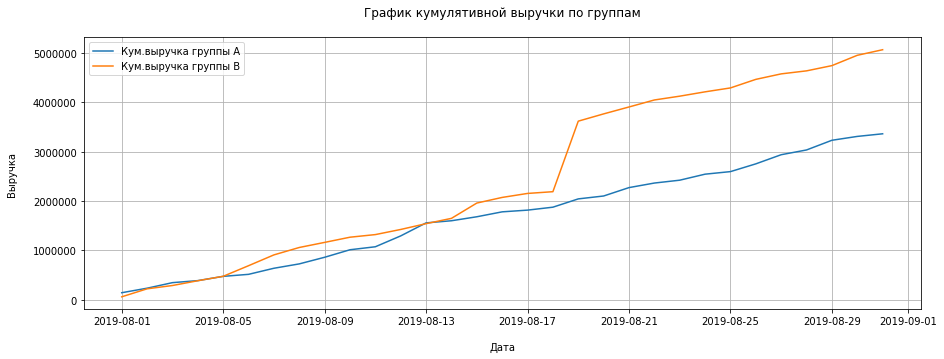

In [20]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(15,5))
#Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Кум.выручка группы A')
#Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Кум.выручка группы B')
plt.title('График кумулятивной выручки по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Выручка\n')
plt.grid()
plt.legend() ;

Наблюдается резкий скачек в графике у группы В, возможно имеют место аномально большое количество заказов или аномально высокий средний чек. Запомним этот момент 19.08.2019

### Построим график кумулятивного среднего чека по группам.  
Сделаем выводы и предположения.

Чтобы построить графики среднего кумулятивного чека по группам — разделим кумулятивную выручку на кумулятивное число заказов.

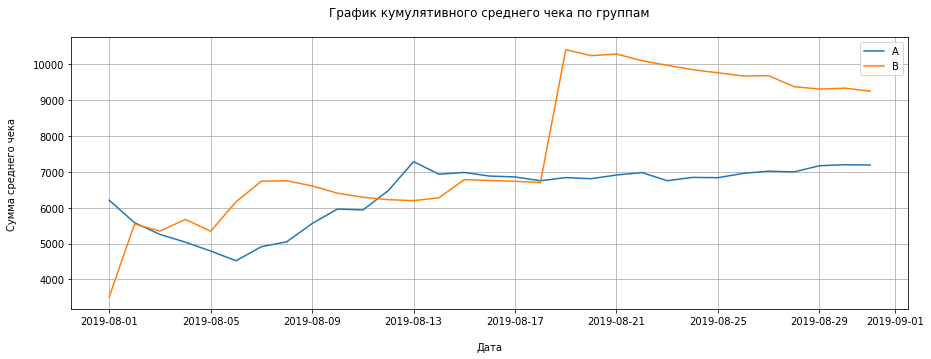

In [21]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Сумма среднего чека\n')
plt.legend() ;

Ком.значение среднего чека по сегментам нестабильно. Возможно имеются аномальные значения (выбросы), которые искажают общую картину.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.  
Сделаем выводы и предположения.


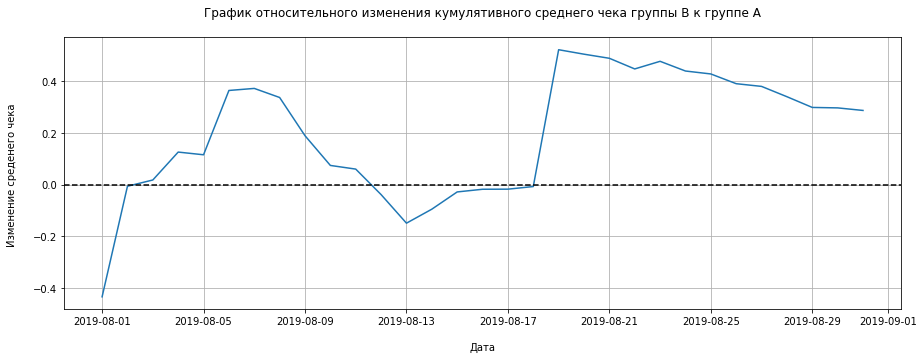

In [22]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A\n  ')
plt.xlabel('\nДата')
plt.ylabel('Изменение среденего чека \n')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') ;

Глядя на график относительного различия в среднем чеке между группами, видим как сильно меняются значения в определенные даты. Веротяно, тогда и были совершены аномальные заказы.

### Построим график кумулятивной конверсии по группам.   
Сделаем выводы и предположения.

''

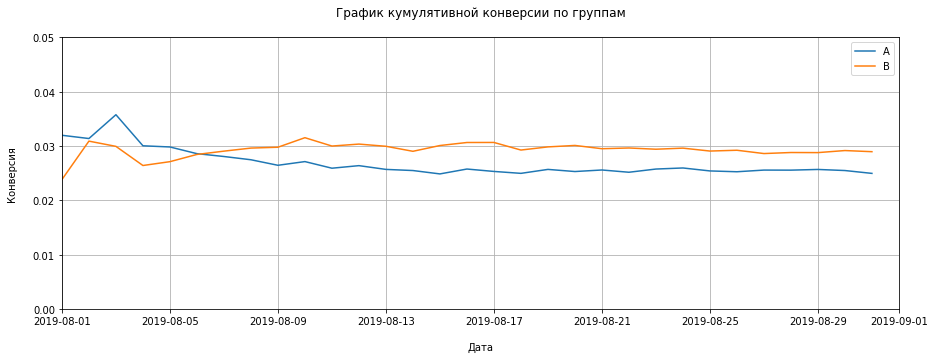

In [23]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Конверсия\n')
# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])
;

Сначала сегмент А имел большую конверсию, но чуть позже сегмент В выровнялся и зафиксировался больше значения сегмента А. 

### Построим график относительного изменения кумулятивной конверсии группы B к группе A.  
Сделаем выводы и предположения.


''

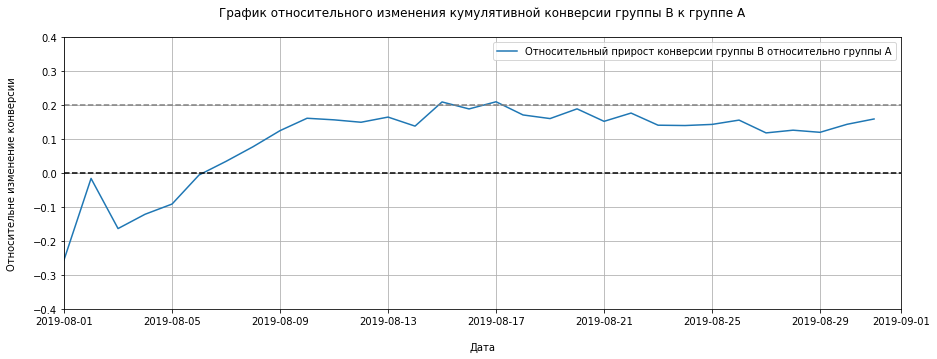

In [24]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.4, 0.4])
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A\n  ')
plt.xlabel('\nДата')
plt.ylabel('Относительне изменение конверсии\n')
;

Почти с самого начала группа В лидирует по конверсии. Приняла стабильные +15% относительно группы А.

### Построим точечный график количества заказов по пользователям.   
Сделаем выводы и предположения.


''

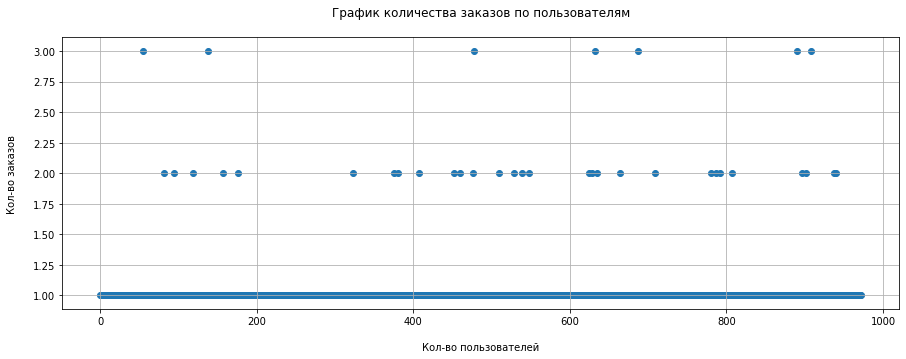

In [25]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False). \
                                                                        agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['user_id','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)

# серия из чисел от 0 до количества наблюдений в ordersByUsers
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График количества заказов по пользователям\n  ')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Кол-во заказов\n')
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
;

Больше всего пользователей совершивших 1 заказ.  
Совершивших 2 заказа значительно меньше. Совершивших 3 заказа единицы, возможно они будут являться выбросами, стоит посчитать выборочные перцентили.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.  
Выберем границу для определения аномальных пользователей.


In [26]:
# Метод np.percentile('column', [percentile1, percentile2]) находит перцентили.
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


95% пользователей овершают не больше 1 заказа, 99% совершают 2 заказа, аномальным будет всё, что и более этого.


### Построим точечный график стоимостей заказов.   
Сделаем выводы и предположения.


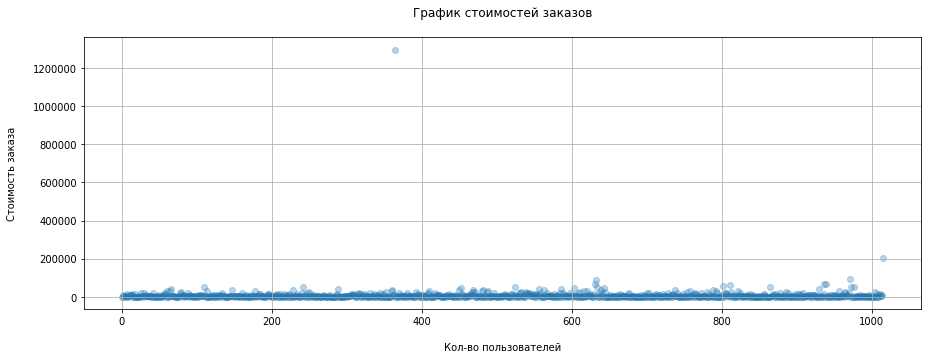

In [27]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов\n ')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Стоимость заказа\n')
plt.scatter(x_values, orders['revenue'], alpha=0.3);

График не очень нагляный из-за наличия двух аномальных значений.  
Посмотрим поближе, для это уберем очевидные выбросы с 'revenue' большим 200000

In [28]:
#Посмотрим точные суммы аномальных заказов.
orders['revenue'].sort_values().tail()

743       67990
744       86620
1136      92550
1196     202740
425     1294500
Name: revenue, dtype: int64

Один аномальный заказ на сумму 1294500, второй на 202740.

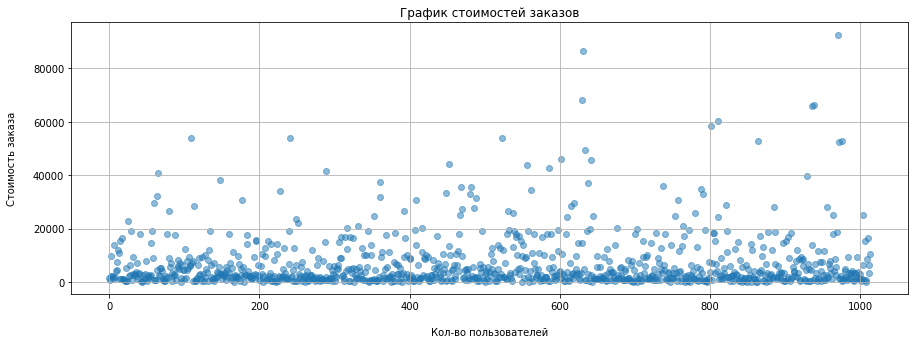

In [29]:
norm_orders = orders[orders['revenue']<=200000]['revenue']
xn_values = pd.Series(range(0,len(norm_orders)))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Стоимость заказа\n')
plt.scatter(xn_values, norm_orders, alpha=0.5);

Большая часть всех заказов не дороже 20000. Более точное распределение посмотрим с помощью перцентилей.

### Посчитаем 95-й и 99-й перцентили стоимости заказов.  
Выберем границу для определения аномальных заказов.


In [30]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Не более чем у 95% заказов чек выше 26785 рублей, и не более чем у 1% дороже 53904 рублей.  
За границу для определения аномальных заказов примем значение 53904.

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.    
Сделаем выводы и предположения.


Начнём с подготовки данных.  
Соберем в общую таблицу все данные по заказам и визитам, добавив кумулятивные показатели.  

In [31]:
orders.sample()

,transactionId,visitorId,date,revenue,group
657,2081053731,3572819427,2019-08-26,7024,A


In [32]:
visitors.sample()

,date,group,visitors
54,2019-08-24,B,378


In [33]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [34]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [35]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Теперь мы можем посчитать статистическую значимость различия в конверсии между группами.  
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [36]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов.  
Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни

In [37]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


**За нулевую гипотезу H0 примем** - статистически значимых различий в конверсиях между группами нет.  
**Тогда альтернативная гипотеза Н1** - статистически значимые различия есть.

In [38]:
#Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой
display("alpha = 0.05")
display("p-value = {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
display("относительный прирост конверсии группы B = {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

'alpha = 0.05'

'p-value = 0.011'

'относительный прирост конверсии группы B = 0.160'

p-value = 0.011 меньше 0.05. Поэтому нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, - отвергаем.  
Это значит по «сырым» данным в конверсии между группами A и B есть статистически значимые различия. 
А относительный прирост группы В к А равен 16% 

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
Сделаем выводы и предположения.


**За нулевую гипотезу H0 примем** - статистически значимых различий в среднемчеке между группами нет.  
**Тогда альтернативная гипотеза Н1** - статистически значимые различия есть.

In [39]:
display("alpha = 0.05")
display("p-value = {0:.3f}".format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
display("Относительный показатель 'B' и 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

'alpha = 0.05'

'p-value = 0.829'

"Относительный показатель 'B' и 'A' = 0.287"

p-value = 0.829 значительно больше 0.05, поэтому можно считать, что значимых различий в среднем чеке между группами нет. По "сырым" данным средние чеки похожи. 
При этом средний чек группы B значительно выше среднего чека группы A (почти на 29%)

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 
Сделаем выводы и предположения.


Приступаем к подготовке очищенных от аномалий данных.  
В предыдущих расчётах мы приняли за аномальных пользователей тех, кто: 
- совершил 3 и больше заказов
- совершил заказ дороже 53904 рублей.  
Сделаем срезы пользователей:
- с числом заказов больше 2 — usersWithManyOrders
- совершивших заказы дороже 53904 — usersWithExpensiveOrders.  
Объединим их в таблицу abnormalUsers. 
Посмотрим количество аномальных пользователей методом shape()

In [40]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
display(abnormalUsers.head(5))
print("Всего аномальных пользователей =" ,len(abnormalUsers)) 

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64

Всего аномальных пользователей = 16


Всего 16 аномальных пользователей. Не так уж и много. Посмотрим, как изменятся расчеты без их участия.

In [41]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), \
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), \
                                       name='orders')],axis=0) 

**За нулевую гипотезу H0 примем** - статистически значимых различий в конверсиях между группами нет.  
**Тогда альтернативная гипотеза Н1** - статистически значимые различия есть.

In [42]:
#Применим статистический критерий Манна-Уитни к полученным выборкам
print("alpha =",0.05)
print("p-value = {0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

alpha = 0.05
p-value = 0.007
Относительный показатель 'B' и 'A' = 0.189


p-value = 0.007 меньше 0.05. Поэтому, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, - отвергаем. 
Это значит: и по «очищенным» данным в конверсии групп A и B есть статистически значимые различия. А относительный выигрыш группы "B" над "A" равен почти 19% (выше, чем с «сырыми» данными - 16%) 

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.  
Сделаем выводы и предположения.


Выведем p-value для сравнения средних чеков между очищенными группами.

**За нулевую гипотезу H0 примем:** "статистически значимых различий в средних чеках между группами нет".  
**Тогда альтернативная гипотеза Н1** - статистически значимые различия есть.

In [43]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], alternative = 'two-sided')[1]))

print("Относительный показатель В и А = {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

alpha = 0.05
p-value = 0.788
Относительный показатель В и А = -0.032


P-value = 0.788, значительно больше 0.05. Поэтому можем считать, что в среднем чеке нет различий (как и с "сырыми" данными). 
А вот средний чек группы B оказался незначительно (на 3%) ниже среднего чека группы A, в то время как по "сырым" данным, он был больше почти на ~29%. 
Вот так ощутимо повлияли на результаты наши аномальные заказы с большими суммами.

### Примите решение по результатам теста и объясните его. 

Варианты решений:  
1. Остановить тест, зафиксировать победу одной из групп. 
2. Остановить тест, зафиксировать отсутствие различий между группами. 
3. Продолжить тест.


Мы выяснили, что у группы В конверсии выше на 19% по "очищенным" данным и на 16% по "сырым", а средние чеки групп по "очищенным данным" примерно одинаковые.  

Основываясь на результатах проведенного А/В теста, рекомендую остановить тест и зафиксировать победу группы В по показателю конверсии. Дальше отдел маркетинга может начать работу по стимуляции к увеличению среднего чека.